In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [3]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [4]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [5]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

Dropping 0 entries of corpus, due to nan ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
36it [00:00, 352.95it/s]

Starting tokenization ...


1261it [00:04, 288.74it/s]


### tfidf

In [6]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

# find optimal k
TODO

# Clustering

In [7]:
def fit_model(model, corpus):
    model.fit(corpus)

def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, vectorizer, corpus, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(model.labels_ == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters
    
model = SpectralClustering(n_clusters=num_topics)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer, corpus)


Top terms per cluster:
Cluster 0:
('learning', 'loss', 'bound', 'label', 'algorithm', 'rate', 'class', 'sample', 'function', 'complexity')


Cluster 1:
('data', 'learning', 'algorithm', 'model', 'problem', 'method', 'set', 'based', 'time', 'approach')


Cluster 2:
('learning', 'machine', 'data', 'library', 'python', 'algorithm', 'package', 'model', 'toolbox', 'source')


Cluster 3:
('policy', 'learning', 'algorithm', 'model', 'method', 'iteration', 'action', 'gradient', 'based', 'function')


Cluster 4:
('graph', 'learning', 'model', 'problem', 'data', 'random', 'based', 'algorithm', 'vertex', 'graphical')


Cluster 5:
('clustering', 'cluster', 'algorithm', 'density', 'data', 'graph', 'based', 'spectral', 'model', 'method')


Cluster 6:
('model', 'feature', 'graphical', 'selection', 'algorithm', 'method', 'data', 'sparse', 'lasso', 'variable')


Cluster 7:
('causal', 'effect', 'data', 'variable', 'method', 'model', 'algorithm', 'discovery', 'set', 'approach')


Cluster 8:
('model', 'in

the words are similar to kmeans, but the composition is different

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


In [8]:
def plot(model, corpus, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()

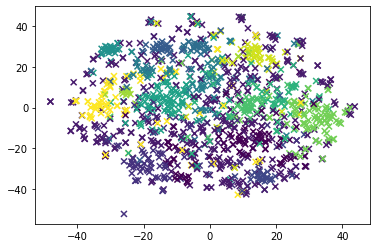

In [9]:
plot(model, tfidf_corpus)

looks like chaos

# Remove words which appear often in all clusters

In [10]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 14, 'data': 11, 'model': 11, 'method': 11, 'learning': 9, 'function': 5, 'problem': 5, 'based': 5, 'approach': 3, 'regression': 3, 'bound': 2, 'rate': 2, 'set': 2, 'gradient': 2, 'graph': 2, 'graphical': 2, 'variable': 2, 'rank': 2, 'community': 2, 'loss': 1, 'label': 1, 'class': 1, 'sample': 1, 'complexity': 1, 'time': 1, 'machine': 1, 'library': 1, 'python': 1, 'package': 1, 'toolbox': 1, 'source': 1, 'policy': 1, 'iteration': 1, 'action': 1, 'random': 1, 'vertex': 1, 'clustering': 1, 'cluster': 1, 'density': 1, 'spectral': 1, 'feature': 1, 'selection': 1, 'sparse': 1, 'lasso': 1, 'causal': 1, 'effect': 1, 'discovery': 1, 'inference': 1, 'process': 1, 'gaussian': 1, 'variational': 1, 'bayesian': 1, 'estimator': 1, 'distributed': 1, 'kernel': 1, 'space': 1, 'mean': 1, 'stochastic': 1, 'optimization': 1, 'convex': 1, 'convergence': 1, 'non': 1, 'tensor': 1, 'decomposition': 1, 'latent': 1, 'topic': 1, 'matrix': 1, 'low': 1, 'co

most common words are similar to kmeans

In [11]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [12]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
24it [00:00, 235.33it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:04, 256.49it/s]


In [13]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [14]:
model_stopwords = SpectralClustering(n_clusters=num_topics)
fit_model(model_stopwords, tfidf_corpus_stopwords)
clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('machine', 'library', 'python', 'package', 'toolbox', 'source', 'multi', 'implementation', 'classification', 'open')


Cluster 1:
('regression', 'estimator', 'distributed', 'function', 'rate', 'linear', 'kernel', 'error', 'approach', 'high')


Cluster 2:
('network', 'neural', 'community', 'node', 'layer', 'deep', 'structure', 'time', 'problem', 'prediction')


Cluster 3:
('problem', 'set', 'based', 'approach', 'time', 'function', 'feature', 'result', 'distribution', 'using')


Cluster 4:
('inference', 'gaussian', 'process', 'variational', 'bayesian', 'approach', 'latent', 'approximation', 'distribution', 'posterior')


Cluster 5:
('causal', 'effect', 'variable', 'discovery', 'set', 'approach', 'inference', 'cause', 'treatment', 'non')


Cluster 6:
('matrix', 'rank', 'low', 'bound', 'completion', 'covariance', 'problem', 'norm', 'approximation', 'error')


Cluster 7:
('graph', 'problem', 'based', 'random', 'vertex', 'graphical', 'distribution', 'markov

In [15]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 8, 'function': 7, 'based': 5, 'approach': 4, 'distribution': 4, 'bound': 4, 'regression': 3, 'feature': 3, 'approximation': 3, 'variable': 3, 'matrix': 3, 'estimator': 2, 'distributed': 2, 'rate': 2, 'kernel': 2, 'error': 2, 'high': 2, 'community': 2, 'time': 2, 'set': 2, 'result': 2, 'inference': 2, 'latent': 2, 'non': 2, 'rank': 2, 'graph': 2, 'graphical': 2, 'gradient': 2, 'machine': 1, 'library': 1, 'python': 1, 'package': 1, 'toolbox': 1, 'source': 1, 'multi': 1, 'implementation': 1, 'classification': 1, 'open': 1, 'linear': 1, 'network': 1, 'neural': 1, 'node': 1, 'layer': 1, 'deep': 1, 'structure': 1, 'prediction': 1, 'using': 1, 'gaussian': 1, 'process': 1, 'variational': 1, 'bayesian': 1, 'posterior': 1, 'causal': 1, 'effect': 1, 'discovery': 1, 'cause': 1, 'treatment': 1, 'low': 1, 'completion': 1, 'covariance': 1, 'norm': 1, 'random': 1, 'vertex': 1, 'markov': 1, 'clustering': 1, 'density': 1, 'cluster': 1, 'estimation

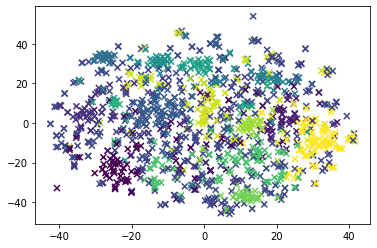

In [16]:
plot(model_stopwords, tfidf_corpus_stopwords)

Cluster looks a little bit better than before? But still not good. 

# LSA 

In [17]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

In [18]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = SpectralClustering(n_clusters=num_topics)
fit_model(model_lsa, X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, corpus, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('policy', 'learning', 'algorithm', 'problem', 'model', 'reinforcement', 'control', 'action', 'function', 'agent')


Cluster 1:
('learning', 'loss', 'class', 'label', 'algorithm', 'bound', 'classifier', 'complexity', 'classification', 'sample')


Cluster 2:
('algorithm', 'learning', 'data', 'method', 'problem', 'function', 'model', 'optimization', 'approach', 'based')


Cluster 3:
('regression', 'method', 'model', 'lasso', 'data', 'high', 'estimator', 'selection', 'dimensional', 'variable')


Cluster 4:
('network', 'model', 'neural', 'data', 'learning', 'layer', 'deep', 'community', 'method', 'algorithm')


Cluster 5:
('graph', 'vertex', 'problem', 'based', 'learning', 'random', 'model', 'algorithm', 'data', 'graphical')


Cluster 6:
('model', 'data', 'learning', 'algorithm', 'feature', 'method', 'graphical', 'set', 'variable', 'high')


Cluster 7:
('algorithm', 'method', 'stochastic', 'optimization', 'gradient', 'convex', 'problem', 'function', 'conve

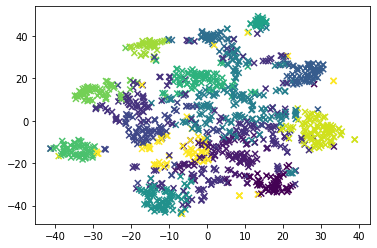

In [19]:
plot(model_lsa, X, n_components=n_components)

In [20]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
model_lsa_stopwords = SpectralClustering(n_clusters=num_topics)
fit_model(model_lsa_stopwords, X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_lsa_stopwords, vectorizer_stopwords, corpus_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('graphical', 'covariance', 'gaussian', 'matrix', 'high', 'dimensional', 'graph', 'estimator', 'estimation', 'network')


Cluster 1:
('problem', 'function', 'optimization', 'based', 'approach', 'optimal', 'result', 'set', 'bound', 'sample')


Cluster 2:
('feature', 'class', 'set', 'classification', 'classifier', 'task', 'problem', 'approach', 'prediction', 'label')


Cluster 3:
('kernel', 'regression', 'function', 'mean', 'density', 'based', 'distribution', 'rate', 'approximation', 'space')


Cluster 4:
('causal', 'variable', 'effect', 'latent', 'set', 'approach', 'discovery', 'inference', 'non', 'cause')


Cluster 5:
('policy', 'based', 'action', 'reinforcement', 'space', 'iteration', 'problem', 'gradient', 'control', 'function')


Cluster 6:
('stochastic', 'gradient', 'optimization', 'convex', 'problem', 'function', 'convergence', 'non', 'distributed', 'descent')


Cluster 7:
('matrix', 'rank', 'low', 'bound', 'completion', 'tensor', 'norm', 'problem

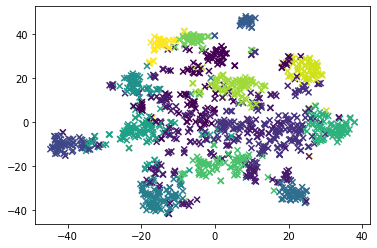

In [21]:
plot(model_lsa_stopwords, X, n_components=n_components)

# Spectral Embedding

In [22]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [23]:
model_spectral = SpectralClustering(n_clusters=num_topics)
model_spectral.fit(tfidf_corpus_spec_embedding_array)
#pickle.dump(model_spectral, open('spectral_clustering_data/model_spectral', 'wb'))

SpectralClustering(n_clusters=15)

In [24]:
clusters_spectral = print_and_get_clusters(model_spectral, vectorizer_spec_embedding, corpus)

Top terms per cluster:
Cluster 0:
('learning', 'algorithm', 'method', 'problem', 'kernel', 'data', 'function', 'optimization', 'bound', 'model')


Cluster 1:
('model', 'data', 'algorithm', 'method', 'matrix', 'graph', 'network', 'learning', 'problem', 'approach')


Cluster 2:
('discrete', 'hilbert', 'space', 'dirac', 'kernel', 'mass', 'reproducing', 'set', 'corresponding', 'countable')


Cluster 3:
('feature', 'hot', 'linear', 'one', 'penalization', 'continuous', 'model', 'binarsity', 'encoded', 'encoding')


Cluster 4:
('attribute', 'bayes', 'naive', 'weighting', 'classifier', 'ha', 'algorithm', 'approach', 'assumption', 'conditional')


Cluster 5:
('wavelet', 'analysis', 'decomposition', 'forest', 'function', 'random', 'sparse', 'application', 'approach', 'approximation')


Cluster 6:
('dbms', 'rbms', 'centered', 'centering', 'value', 'binary', 'offset', 'bm', 'mean', 'normal')


Cluster 7:
('tensor', 'manifold', 'data', 'gesture', 'geometry', 'space', 'using', 'method', 'product', '

New words in comparison with no dimensionality reduction or LSA.

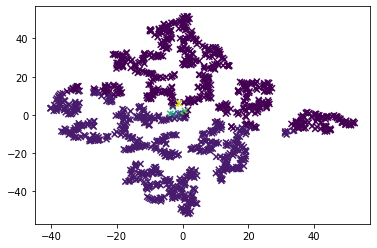

In [27]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, n_components=2)

Hardly 2 clusters are found.

# Metrics
Metrics provided from sklearn, that don't need true labels:

    metrics.silhouette_score
    metrics.calinski_harabasz_score
    metrics.davies_bouldin_score
    
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [26]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

scores = []

score = list(calc_scores(tfidf_corpus, model))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)
score = list(calc_scores(tfidf_corpus, model_lsa))
score.insert(0, 'model_lsa')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_lsa_stopwords))
score.insert(0, 'model_lsa_stopwords')
scores.append(score)
score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.011129                 5.147178   
1    model with custom stopwords          0.011256                 5.100888   
2                      model_lsa          0.011581                 4.783920   
3            model_lsa_stopwords          0.011773                 4.800205   
4  model with spectral embedding         -0.192237                46.068646   

   davies_bouldin_score  
0              6.649149  
1              6.700054  
2              7.653376  
3              7.667915  
4              1.384085  


scored suggest that spectral clustering works better than kmeans. Very big calinski_harabasz_score  and very small davies_bouldin_score, which is good. But the silhouette score is not good.